# Gaussian Process Regression

After a sequence of preliminary posts ([Sampling from a Multivariate Normal Distribution](https://juanitorduz.github.io/multivariate_normal/) and [Regularized Bayesian Regression as a Gaussian Process](https://juanitorduz.github.io/reg_bayesian_regression/)),  I want to expole a concrete example of a **gaussian process regression**. We continue following [Gaussian Processes for Machine Learning, Ch 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf). Another recomended reference is the work on [Gaussian Processes for Timeseries Modeling](http://www.robots.ox.ac.uk/~sjrob/Pubs/philTransA_2012.pdf) by S. Roberts, M. Osborne, M. Ebden, S. Reece, N. Gibson & S. Aigrain.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Data Samples

We consider de model \\(y = f(x) + \varepsilon\\), where \\(\varepsilon \sim N(0, \sigma_n)\\). Here \\(f\\) does not need to be a linear function of \\(x\\). As a concrete example, let us consider (1-dim problem)

$$
f(x) = \sin(2\pi x) + \sin(4\pi x)
$$

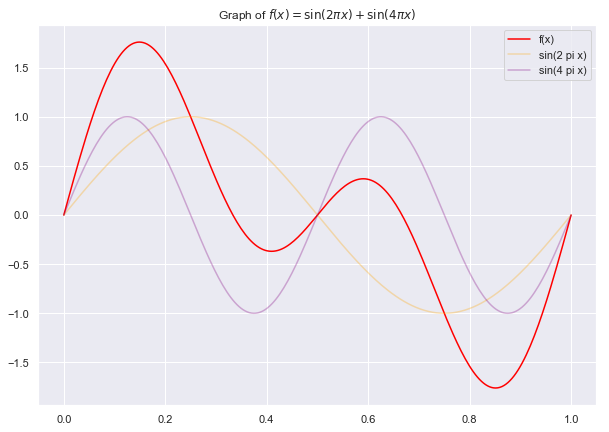

In [2]:
# Define dimension.
d = 1
# Number of samples (training set). 
n = 250

x = np.linspace(start=0, stop=1, num=n)

def f(x):
    
    f = np.sin((2*np.pi)*x) + np.sin((4*np.pi)*x)
    
    return(f)

f_x = f(x)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot function f. 
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");
# Plot function components.
sns.lineplot(x=x, y=np.sin((2*np.pi)*x), color="orange", label="sin(2 pi x)", alpha = 0.3);
sns.lineplot(x=x, y=np.sin((4*np.pi)*x), color="purple", label="sin(4 pi x)", alpha = 0.3);

ax.legend(loc="upper right")
ax.set_title(r"Graph of $f(x) = \sin(2\pi x) + \sin(4\pi x)$");

Next, we generate some training sample observsations:

In [3]:
# Error standar deviation. 
sigma_n = 0.4

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Observed target variable. 
y = f_x + epsilon

Let us see the error distribution.

/Users/juanitorduz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


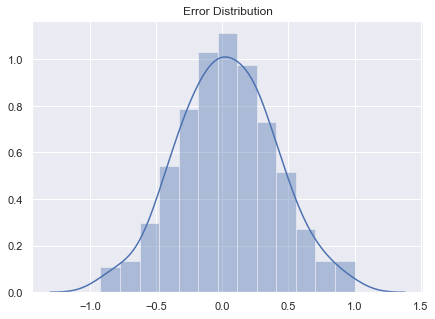

In [4]:
fig, ax = plt.subplots(figsize=(7,5))
# Plot errors. 
sns.distplot(epsilon)

ax.set_title("Error Distribution");

We now visualize the sample data:

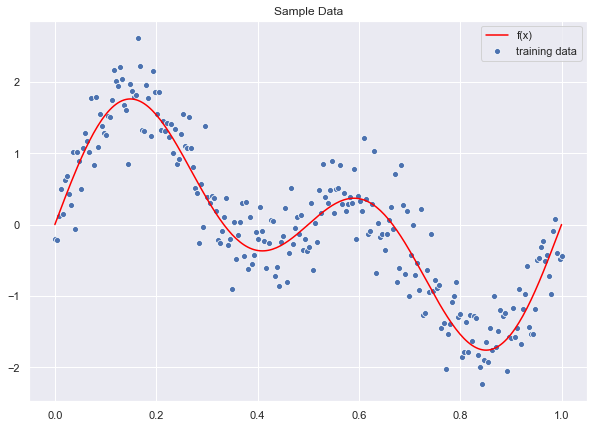

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot training data.
sns.scatterplot(x=x, y=y, label="training data");
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="upper right")
ax.set_title("Sample Data");

We now consider test data points on which we want to generate predictions.

In [6]:
n_star = 50

x_star = np.linspace(start=0, stop=1, num=n_star)

## Kernel Function

Recall that a gaussian process is completely specified by its mean function and covariance (we usually take the mean equal to zero, although it is not necessary). A common choise is the *squared exponential*, 

$$
\text{cov}(f(x_p), f(x_q)) = k_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{1}{2\ell^2} ||x_p - x_q||^2\right)
$$

where \\(\sigma_f , \ell >0 \\) are hyperparameters. Observe that the covariance between two samples are modeled as a function of the inputs. 

**Remark:** *"It can be shown that the squared exponential covariance
function corresponds to a Bayesian linear regression model with an infinite
basis functions number of basis function."* ([Gaussian Processes for Machine Learning, Ch 2.2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf))

In [7]:
def kernel_function(x, y, sigma_f=1, l=1):
    
    """Define squared exponential kernel function."""
    
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    
    return kernel

Let us select the parameters:

In [8]:
l = 0.1
sigma_f = 2

## Compute Covariance Matrices

A key observation, as ilustrated in [Regularized Bayesian Regression as a Gaussian Process](https://juanitorduz.github.io/reg_bayesian_regression/), is that *the specification of the covariance function implies a distribution over functions*. 

Let us denote by \\(K(X, X) \in M_{n}(\mathbb{R})\\), \\(K(X_*, X) \in M_{n_* \times n}(\mathbb{R})\\) and \\(K(X_*, X_*) \in M_{n_*}(\mathbb{R})\\) the covariance matrices applies to \\(x \\) and  \\(x_* \\). 

In [9]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f = 1, l =1):

    """
    Compute components of the covariance matrix of the join distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

We compute the covariance matrices using the function above:

In [10]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

We now visualize each component:

- \\(K(X, X)\\)

In [11]:
K.shape

(250, 250)

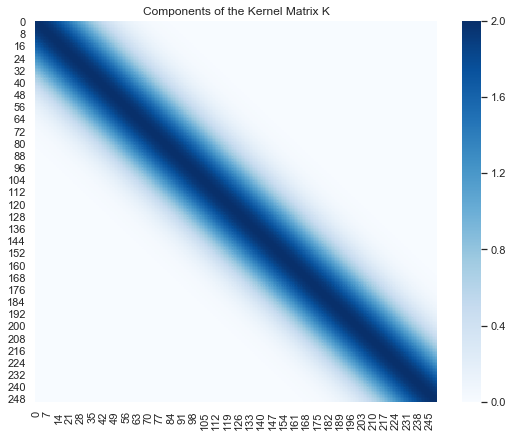

In [12]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K, cmap="Blues", ax=ax)

ax.set_title("Components of the Kernel Matrix K");

- \\(K(X_*, X_*)\\)

In [13]:
K_star2.shape

(50, 50)

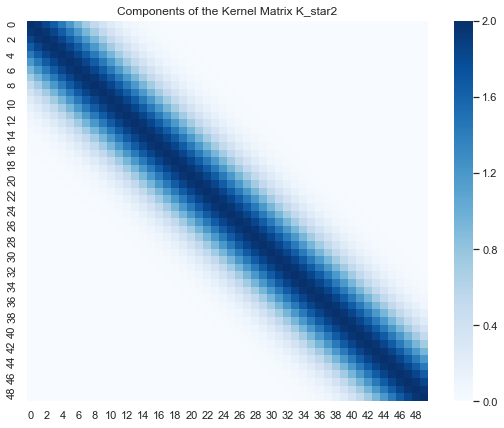

In [14]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K_star2, cmap="Blues", ax=ax)

ax.set_title("Components of the Kernel Matrix K_star2");

- \\(K(X_*, X)\\)

In [15]:
K_star.shape

(50, 250)

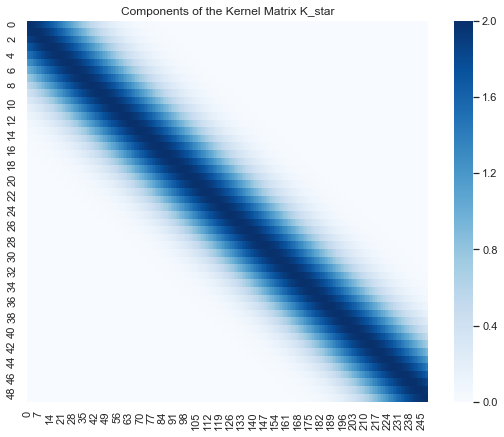

In [16]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K_star, cmap="Blues", ax=ax)

ax.set_title("Components of the Kernel Matrix K_star");

Note how the highest values of the support of all these matrices is localizated around the diagonal. 

## Join Distribution

The join distribution  of \\(y\\) and \\(f_*\\) is given by 

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
N(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term \\(\sigma^2_n I \\) to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix \\(C\\).

In [17]:
a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
a.shape

(300, 250)

In [18]:
b = np.concatenate((K_star.T, K_star2), axis=0)
b.shape

(300, 50)

In [19]:
C = np.concatenate((a, b), axis=1)
C.shape

(300, 300)

In [20]:
# Indeed, 
C.shape == (n + n_star, n + n_star)

True

Let us verify that \\(C\\) is symmetric.

In [21]:
np.all(C.T == C)

True

We can also see this visually:

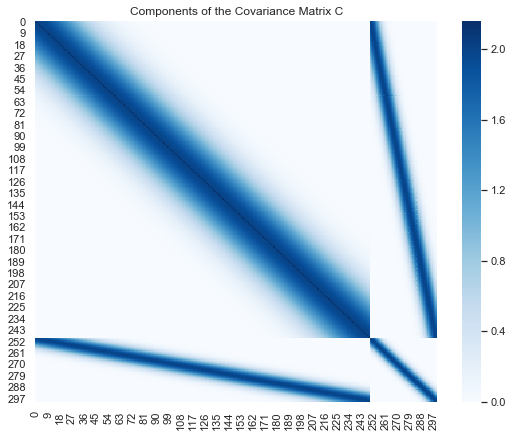

In [22]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=C, cmap="Blues", ax=ax)

ax.set_title("Components of the Covariance Matrix C");

## Prior Distribution 

From the * consistency requirement* og gaussian processes we know that the prior distribution for \\(f_*\\) is \\(N(0, K(X_*, X_*))\\). Let us visualize some sample functions from this prior:

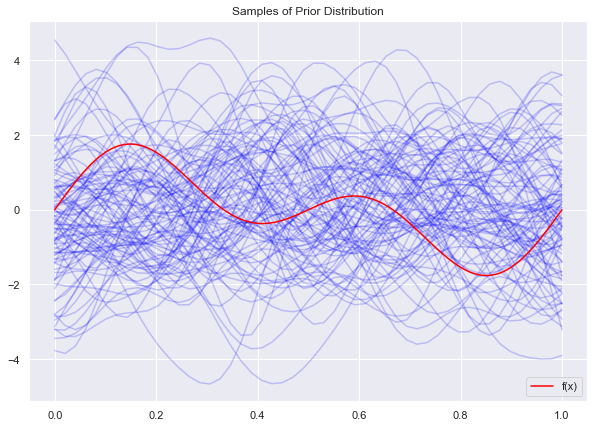

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="lower right")
ax.set_title("Samples of Prior Distribution");

## Conditional Distribution

As described in our main reference, *to get the posterior distribution over functions we need to restrict this joint
prior distribution to contain only those functions which agree with the observed
data points*, that is, we are interested in computing \\(f_*|X, y, X_* \\). Using the results of [Gaussian Processes for Machine Learning, Appendinx A.2](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf), one can show that 

$$
f_*|X, y, X_* 
\sim
N(\bar{f}_*, \text{cov}(f_*))
$$

where 

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}
$$

and 

$$
\text{cov}(f_*) = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*}(\mathbb{R})
$$

We now calculate the parameters of the posterior distribution:

In [24]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""
    
    n = K.shape[0]
    
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [25]:
# Compute posterior mean and covariance. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

Let us visualize the covariance components.

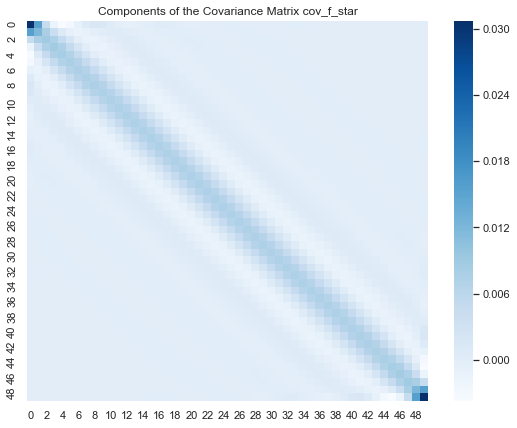

In [26]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=cov_f_star, cmap="Blues", ax=ax)

ax.set_title("Components of the Covariance Matrix cov_f_star");

Let us now sample from the posterior distribution:

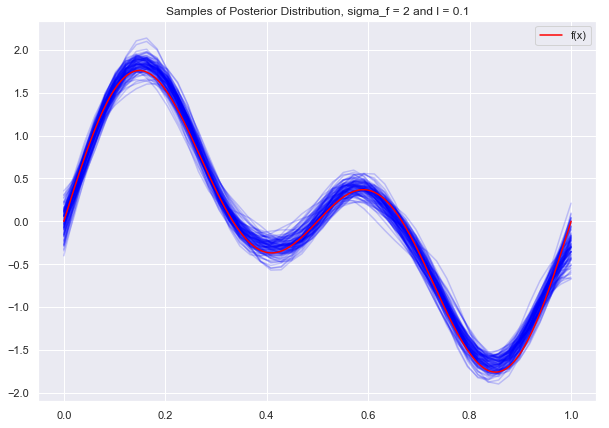

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2);
    

# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="upper right")
ax.set_title("Samples of Posterior Distribution, sigma_f = {} and l = {}".format(sigma_f, l));

## Hyperparameters

We now study the effect of the hyperparameters \\(\sigma_f\\) and \\(\ell\\) of the kernel function defined above. 

- The hyperparameter \\(\sigma_f\\) describes the amplitude of the function. 

- The hyperparameter \\(\ell\\) is a locality parameter, i.e. how far the points interact. 

Let us see some concrete examples:

- \\(\sigma_f = 2\\) and \\(\ell = 1\\)

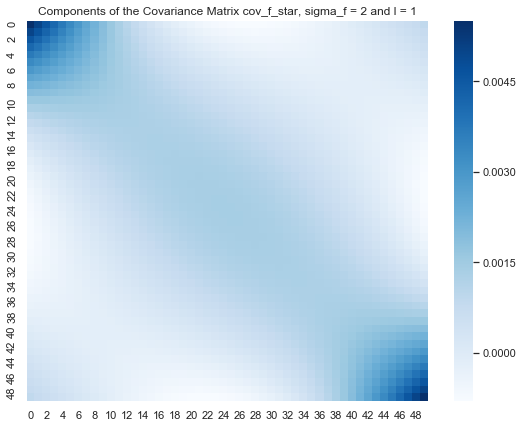

In [28]:
l = 1
sigma_f = 2

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=cov_f_star, cmap="Blues", ax=ax)

ax.set_title("Components of the Covariance Matrix cov_f_star, sigma_f = {} and l = {}".format(sigma_f, l));

In this case the values of the posterior covariance matrix are not that localized. This means that we expect points far away can still have some interation, i.e. the fit becomes more global. Let us plot the resulting fit:

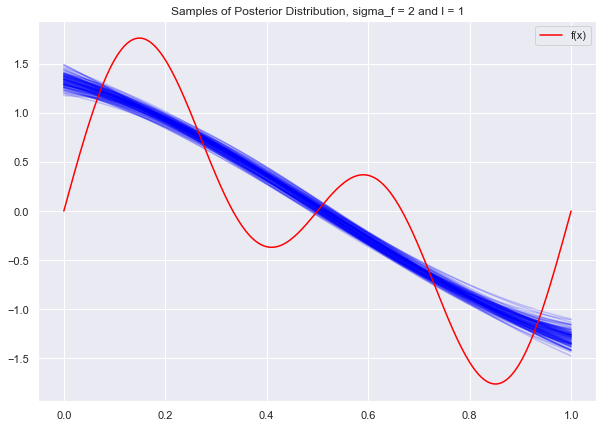

In [29]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = 2, l = 1)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="upper right")
ax.set_title("Samples of Posterior Distribution, sigma_f = {} and l = {}".format(sigma_f, l));

- \\(\sigma_f = 2\\) and \\(\ell = 0.001\\)

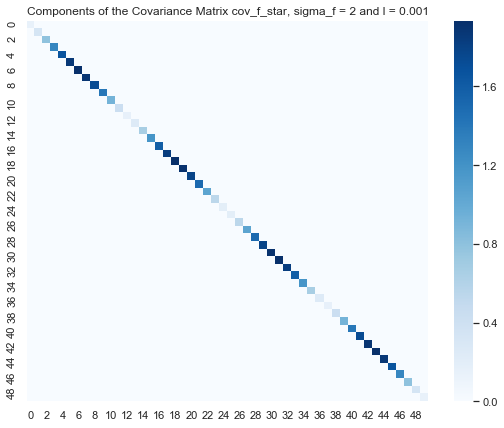

In [30]:
l = 0.001
sigma_f = 2

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=cov_f_star, cmap="Blues", ax=ax)

ax.set_title("Components of the Covariance Matrix cov_f_star, sigma_f = {} and l = {}".format(sigma_f, l));

In contrast, we see that for these set of hyper parameters the higher values of the posterior covariance matrix are concentrated along the diagonal. This means that we expect points far away to have no effect on each other, i.e. the fit becomes more local. Let us plot the resulting fit:

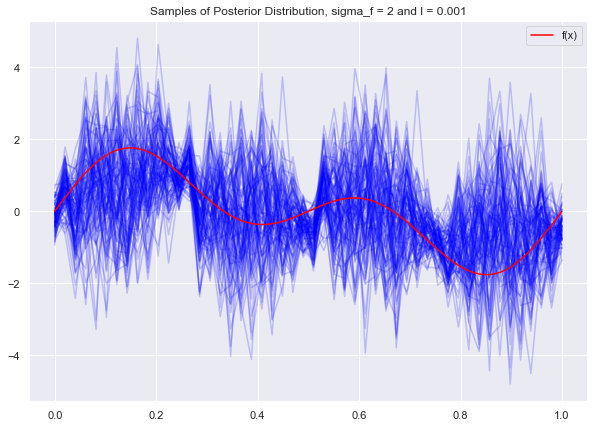

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="upper right")
ax.set_title("Samples of Posterior Distribution, sigma_f = {} and l = {}".format(sigma_f, l));

Hence, we see that the hyperparameter \\(\ell\\) somehow enoces the "complexity" and "locality" of the model. 

- \\(\sigma_f = 25 \\) and \\(\ell = 0.01\\)

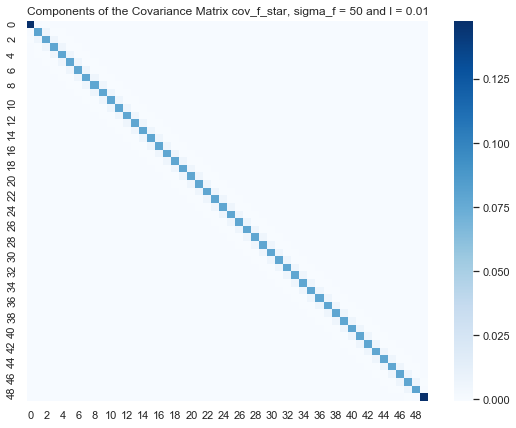

In [32]:
l = 0.01
sigma_f = 50

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=cov_f_star, cmap="Blues", ax=ax)

ax.set_title("Components of the Covariance Matrix cov_f_star, sigma_f = {} and l = {}".format(sigma_f, l));

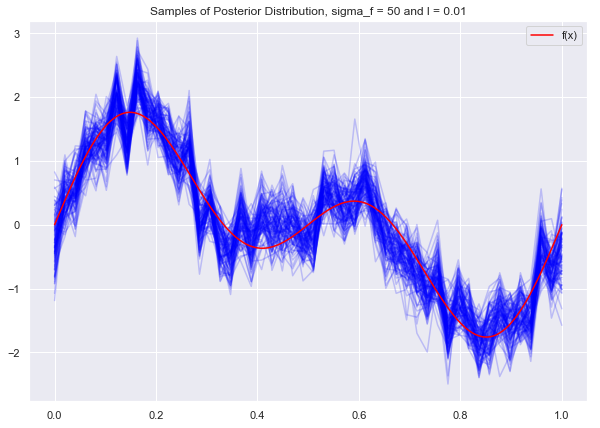

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");

ax.legend(loc="upper right")
ax.set_title("Samples of Posterior Distribution, sigma_f = {} and l = {}".format(sigma_f, l));

The hyperparameter \\(\sigma_f\\) enoces the amplitude of the fit. 

## GaussianProcessRegressor from Scikit-Learn

Note that in the examples above he had to compute the inverse of \\(K(X,X) + \sigma_n^2 I\\), which can be computationally expensive for larger data sets. A better approach is to use the Cholesky decomposition of \\(K(X,X) + \sigma_n^2 I\\) as describet in [Gaussian Processes for Machine Learning, Ch 2 Algorithm 2.1](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf). This is actually the implementation used by [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor). We now describe how to fit a GaussianProcessRegressor model using Scikit-Learn and compare it with the results obtained above. Please refer to the [docomentation example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html) to get more detailed information. 

###  Kernel Object 

There are my [kernel functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process) implemented in Scikit-Learn. Let us see how define the squared exponential:

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = C(sigma_f, (1e-3, 1e3)) * RBF(l, (1e-3, 1e3))

The tuples on each kernel component represent the lower and upper bound of the hyperparameters. The gaussian process fit automatically selects the best hyperparameters which maximize the log-marginal likelihood. The marginal likelihood is the integral of the likelihood times the prior.

### GaussianProcessRegressor

Now we define de [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) object. 

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n, n_restarts_optimizer=10)

We reshape the variables into matrix form.

In [36]:
X = x.reshape(n, d)
X_star = x_star.reshape(n_star, d)

In [37]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)

GaussianProcessRegressor(alpha=0.4, copy_X_train=True,
             kernel=1.41**2 * RBF(length_scale=0.1),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### Predictions

In [38]:
# Make the prediction on test set.
y_pred = gp.predict(X_star)

Let us plot the prediction. 

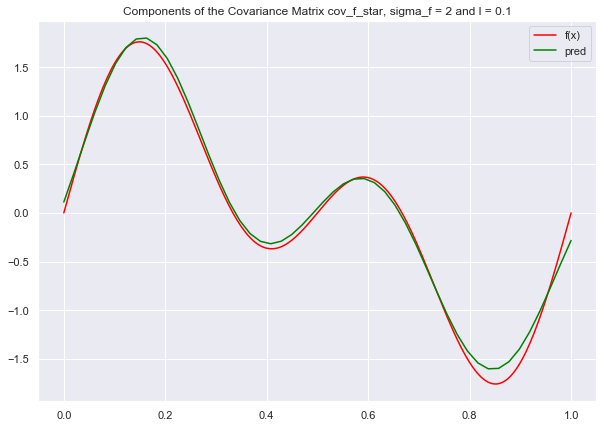

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="upper right")
ax.set_title("Prediction GaussianProcessRegressor, sigma_f = {} and l = {}".format(sigma_f, l));
ax.set_title("Components of the Covariance Matrix cov_f_star, sigma_f = {} and l = {}".format(sigma_f, l));

Next, we plot this prediction against many samples from the posterior distribution obtained above.

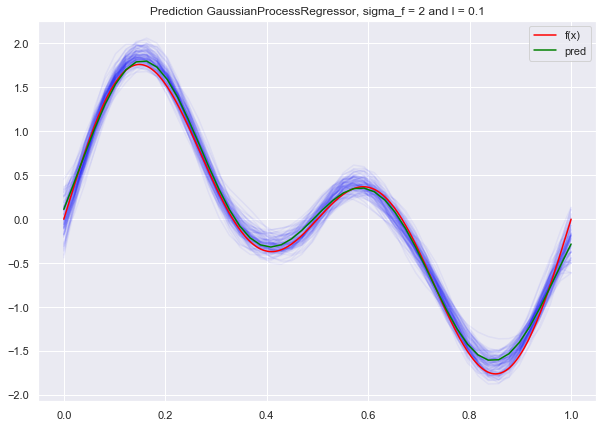

In [40]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.05);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="upper right")
ax.set_title("Prediction GaussianProcessRegressor, sigma_f = {} and l = {}".format(sigma_f, l));

### Confidence Interval

Let us compute the confidence intervals:

In [41]:
# Generate samples from posterior distribution. 
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=100)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

We now plot the confidence interval corrsponding to a corridor coresponding to two standard deviations.

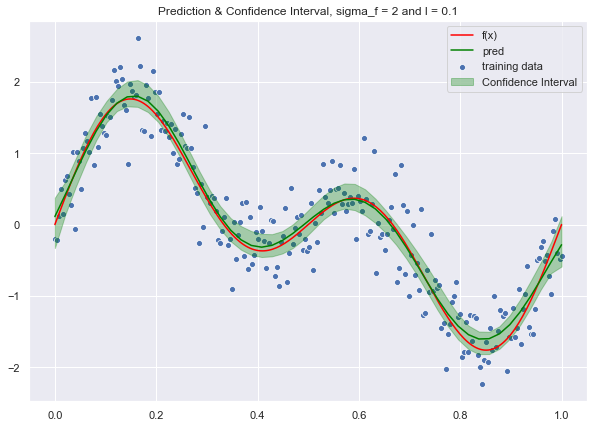

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot training data.
sns.scatterplot(x=x, y=y, label="training data");

# Plot corridor. 
plt.fill_between(x=x_star, 
                 y1=(y_hat - 2*y_hat_sd), 
                 y2=(y_hat + 2*y_hat_sd), 
                 color = "green", alpha = 0.3, 
                 label = "Confidence Interval")

# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color="red", label = "f(x)");
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="upper right")
ax.set_title("Prediction & Confidence Interval, sigma_f = {} and l = {}".format(sigma_f, l));

## Summary & Final Example

In this post we have studied and experimented the fundamentals of gaussian process regression with the intention to gain some intuition about it. Let us finalize with a self-contain example where we only use the tools from Scikit-Learn. 

### Construct Training Set

In [43]:
# Set dimension. 
d = 1
# Number of training points.
n = 500
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Generate function range.
def f(x):
    
    f = np.sin((2*np.pi)*x) + np.sin((4*np.pi)*x) 
    
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

### Construct Test Set

In [44]:
n_star = n + 125
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

### Define Kernel and Model

In [45]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = C(sigma_f, (1e-3, 1e3)) * RBF(l, (1e-3, 1e3))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n, n_restarts_optimizer=10)

### Model Fit + Predictions

In [46]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)

In [47]:
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

### Visualize Results

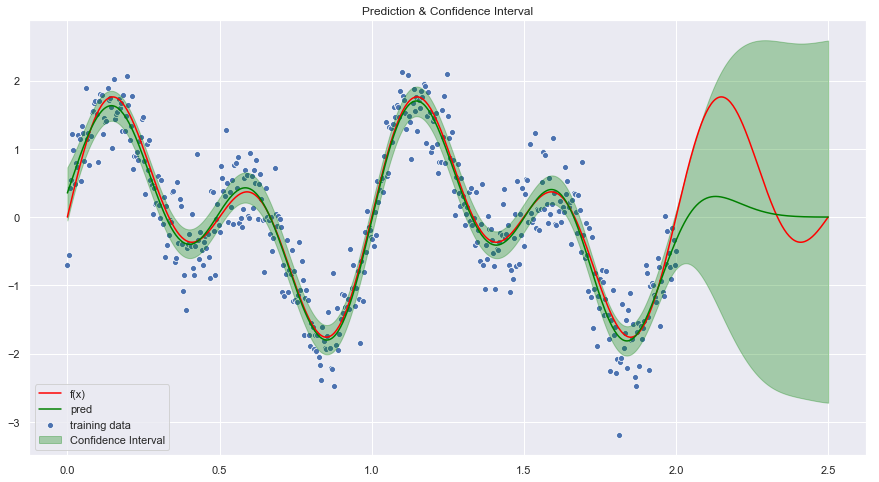

In [48]:
fig, ax = plt.subplots(figsize=(15, 8))

# Plot training data.
sns.scatterplot(x=x, y=y, label="training data");

# Plot "true" linear fit.
sns.lineplot(x=x_star, 
             y=f(x_star), 
             color="red", 
             label = "f(x)");

# Plot corridor. 
plt.fill_between(x=x_star, 
                 y1=(y_hat - 2*y_hat_sd), 
                 y2=(y_hat + 2*y_hat_sd), 
                 color = "green", alpha = 0.3, 
                 label = "Confidence Interval")

# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="lower left")
ax.set_title("Prediction & Confidence Interval");

This is just the begining. There are many questions which are still open:

- How does the hyperparameter selction works?
- Which other kernels are possible? For example see [here](https://scikit-learn.org/stable/modules/gaussian_process.html#basic-kernels).
- How to generate new kernels? Can we combine kernels to get new ones?
- How to apply these techniques to classification problems?

I hope to keep exploring these and more questions in future posts. 